# Demo of SINGLESHOTPOSE

![](https://camo.githubusercontent.com/26a6b23caf09bbf1bfa62d5418dde92160668597/68747470733a2f2f6274656b696e2e6769746875622e696f2f73696e676c655f73686f745f706f73652e706e67)

https://github.com/microsoft/singleshotpose

In [1]:
%load_ext autoreload
%autoreload 2
from skimage.transform import rescale, resize

import os, sys
os.chdir("../")

In [2]:

import time
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import scipy.io
import warnings
from PIL import Image
import trimesh

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import scipy.misc

from darknet import Darknet
import dataset
from utils import *
from MeshPly import MeshPly


In [3]:
test_image_inf = "/mnt/daredevildiag/LINEMOD/LINEMOD/ape/JPEGImages/000038.jpg"
test_image_label = "/mnt/daredevildiag/LINEMOD/LINEMOD/ape/labels/000038.txt"

__Parse configuration pointCloudDisp__

In [4]:
# Parse configuration pointCloudDisp
#data_options = read_data_cfg('cfg/ycbv01.data')
data_options = read_data_cfg('cfg/ape.data')
data_options

{'gpus': '0',
 'num_workers': '10',
 'train': '/mnt/daredevildiag/LINEMOD/LINEMOD/ape/train.txt',
 'valid': '/mnt/daredevildiag/LINEMOD/LINEMOD/ape/test.txt',
 'backup': '/mnt/daredevildiag/LINEMOD/backup/ape',
 'mesh': '/mnt/daredevildiag/LINEMOD/LINEMOD/ape/ape.ply',
 'tr_range': '/mnt/daredevildiag/LINEMOD/LINEMOD/ape/training_range.txt',
 'name': 'ape',
 'diam': '0.103',
 'width': '640',
 'height': '480',
 'fx': '572.4114',
 'fy': '573.5704',
 'u0': '325.2611',
 'v0': '242.0489'}

In [5]:
valid_images = data_options['valid']
print(f'Verify the set file path: {valid_images}')
meshname = data_options['mesh']
print(f'Grid Data for mesh_name: {meshname}')

backupdir = data_options['backup']
print(f'Back up the weight folder: {backupdir}')

name = data_options['name']
print(f'The category name for observation: {name}')

gpus = data_options['gpus']
print(f'Choose which GPU to use : {gpus}')

Verify the set file path: /mnt/daredevildiag/LINEMOD/LINEMOD/ape/test.txt
Grid Data for mesh_name: /mnt/daredevildiag/LINEMOD/LINEMOD/ape/ape.ply
Back up the weight folder: /mnt/daredevildiag/LINEMOD/backup/ape
The category name for observation: ape
Choose which GPU to use : 0


#### Set camera and image parameters

In [6]:
## Camera parameters
fx = float(data_options['fx'])
fy = float(data_options['fy'])
u0 = float(data_options['u0'])
v0 = float(data_options['v0'])

## image Size
im_width = int(data_options['width'])
im_height = int(data_options['height'])

## Model inference Parameters

In [7]:
seed = int(time.time())
os.environ['CUDA_VISIBLE_DEVICES'] = gpus
torch.cuda.manual_seed(seed) # randome seed
save = False  # save results?
visualize = True # viz?
testtime = True  # display inference time
num_classes = 1  # number of categories
testing_samples = 0.0 # test sample

In [8]:
# Corner, drawing wire, the corresponding two points into segments.
edges_corners = [[0, 1], [0, 2], [0, 4], [1, 3], [1, 5], [2, 3], [2, 6], [3, 7], [4, 5], [4, 6], [5, 7], [6, 7]]

In [9]:
# To save
testing_error_trans = 0.0
testing_error_angle = 0.0
testing_error_pixel = 0.0
errs_2d = []
errs_3d = []
errs_trans = []
errs_angle = []
errs_corner2D = []
preds_trans = []
preds_rot = []
preds_corners2D = []
gts_trans = []
gts_rot = []
gts_corners2D = []

## Pointcloud

In [10]:
# Read object model information, get 3D bounding box corners
mesh      = MeshPly(meshname)

vertices  = np.c_[np.array(mesh.vertices), np.ones((len(mesh.vertices), 1))].transpose()
vertices

array([[-0.031255, -0.031445, -0.032168, ...,  0.008632,  0.006388,
         0.007444],
       [ 0.026196,  0.027321,  0.025672, ...,  0.02086 ,  0.02136 ,
         0.020054],
       [ 0.002885,  0.001013,  0.001107, ...,  0.021937,  0.022042,
         0.023583],
       [ 1.      ,  1.      ,  1.      , ...,  1.      ,  1.      ,
         1.      ]])

In [11]:
corners3D = get_3D_corners(vertices)
corners3D

array([[-0.03982 , -0.03982 , -0.03982 , -0.03982 ,  0.036049,  0.036049,
         0.036049,  0.036049],
       [-0.04071 , -0.04071 ,  0.036889,  0.036889, -0.04071 , -0.04071 ,
         0.036889,  0.036889],
       [-0.035134,  0.056635, -0.035134,  0.056635, -0.035134,  0.056635,
        -0.035134,  0.056635],
       [ 1.      ,  1.      ,  1.      ,  1.      ,  1.      ,  1.      ,
         1.      ,  1.      ]])

In [12]:
diam  = float(data_options['diam'])

In [13]:
# Read intrinsic camera parameters
intrinsic_calibration = get_camera_intrinsic(u0, v0, fx, fy)
intrinsic_calibration

array([[572.4114,   0.    , 325.2611],
       [  0.    , 573.5704, 242.0489],
       [  0.    ,   0.    ,   1.    ]])

In [14]:
# Get validation file names
with open(valid_images) as fp:
    tmp_files = fp.readlines()
    valid_files = [item.rstrip() for item in tmp_files]
valid_files[:10]

['LINEMOD/ape/JPEGImages/000000.jpg',
 'LINEMOD/ape/JPEGImages/000001.jpg',
 'LINEMOD/ape/JPEGImages/000002.jpg',
 'LINEMOD/ape/JPEGImages/000003.jpg',
 'LINEMOD/ape/JPEGImages/000005.jpg',
 'LINEMOD/ape/JPEGImages/000006.jpg',
 'LINEMOD/ape/JPEGImages/000007.jpg',
 'LINEMOD/ape/JPEGImages/000008.jpg',
 'LINEMOD/ape/JPEGImages/000010.jpg',
 'LINEMOD/ape/JPEGImages/000011.jpg']

In [15]:
# Specicy model, load pretrained weights, pass to GPU and set the module in evaluation mode
model = Darknet('cfg/yolo-pose.cfg')
model.print_network()
model.load_weights(data_options['backup'] + "/model_backup.weights")
model.cuda()
model.eval()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 max          2 x 2 / 2   416 x 416 x  32   ->   208 x 208 x  32
    2 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    3 max          2 x 2 / 2   208 x 208 x  64   ->   104 x 104 x  64
    4 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    5 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    6 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    7 max          2 x 2 / 2   104 x 104 x 128   ->    52 x  52 x 128
    8 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
    9 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   10 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   11 max          2 x 2 / 2    52 x  52 x 256   ->    26 x  26 x 256
   12 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
   13 conv    256  1 x 

Darknet(
  (models): ModuleList(
    (0): Sequential(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (leaky1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (leaky2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (leaky3): LeakyReLU(negative_slope=0

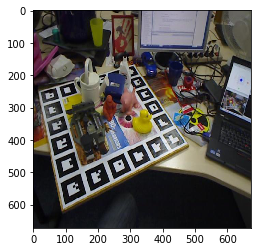

In [16]:
test_width    = model.test_width
test_height   = model.test_height
num_keypoints = model.num_keypoints 
num_labels    = num_keypoints * 2 + 3 # +2 for width, height,  +1 for class label
count = 0

transform = transforms.Compose([transforms.ToTensor(), ])
pic_obj = Image.open(test_image_inf).convert('RGB')
pic_obj = pic_obj.resize((test_width, test_height))
pic_tensor = transform(pic_obj)
# The tensor dimension of the one-dimensional alignment algorithm is increased by the tensor tens.
pic_tensor = pic_tensor[np.newaxis,:]
plt.imshow(pic_obj)

In [17]:
# From the default settings of the original algorithm.
max_num_gt = 50
label = torch.zeros(max_num_gt * num_labels)
tmp = torch.from_numpy(read_truths_args(test_image_label))
tmp = tmp.view(-1)
tsz = tmp.numel()
if tsz > max_num_gt * num_labels:
    label = tmp[0:max_num_gt * num_labels]
elif tsz > 0:
    label[0:tsz] = tmp

In [18]:
target = label
data = pic_tensor

__Process Image__

In [19]:
# Images
img = data[0, :, :, :]
img = img.numpy().squeeze()
img = np.transpose(img, (1, 2, 0))

t1 = time.time()
# Pass data to GPU
data = data.cuda()
target = target.cuda()
# Wrap tensors in Variable class, set volatile=True for inference mode and to use minimal memory during inference
with torch.no_grad():
    data = Variable(data)
t2 = time.time()
# Forward pass
output = model(data).data
t3 = time.time()
# Using confidence threshold, eliminate low-confidence predictions
all_boxes = get_region_boxes(output, num_classes, num_keypoints)
t4 = time.time()

In [20]:
all_boxes

[tensor(0.3444),
 tensor(0.4516),
 tensor(0.3954),
 tensor(0.4991),
 tensor(0.3973),
 tensor(0.4096),
 tensor(0.3267),
 tensor(0.5204),
 tensor(0.3201),
 tensor(0.4296),
 tensor(0.3691),
 tensor(0.4503),
 tensor(0.3672),
 tensor(0.3652),
 tensor(0.3036),
 tensor(0.4693),
 tensor(0.2951),
 tensor(0.3815),
 tensor(0.9206),
 tensor(1.),
 tensor(0)]

### Evaluation - Iterate through all batch elements

In [21]:
def truths_length(truths, max_num_gt=50):
    for i in range(max_num_gt):
        if truths[i][1] == 0:
            return i

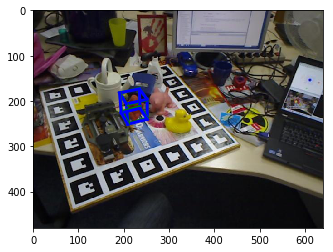

In [22]:
# Iterate through all batch elements
for box_pr, target in zip([all_boxes], [target]):
    # For each image, get all the targets (for multiple object pose estimation, there might be more than 1 target per image)
    truths = target.view(-1, num_keypoints * 2 + 3)
    # Get how many objects are present in the scene
    num_gts = truths_length(truths)
    # Iterate through each ground-truth object
    for k in range(num_gts):
        box_gt = list()
        for j in range(1, 2 * num_keypoints + 1):
            box_gt.append(truths[k][j])
        box_gt.extend([1.0, 1.0])
        box_gt.append(truths[k][0])

        # Denormalize the corner predictions
        # 获取2D groundtruth
        corners2D_gt = np.array(np.reshape(box_gt[:18], [9, 2]), dtype='float32')
        corners2D_pr = np.array(np.reshape(box_pr[:18], [9, 2]), dtype='float32')
        corners2D_gt[:, 0] = corners2D_gt[:, 0] * im_width
        corners2D_gt[:, 1] = corners2D_gt[:, 1] * im_height
        corners2D_pr[:, 0] = corners2D_pr[:, 0] * im_width
        corners2D_pr[:, 1] = corners2D_pr[:, 1] * im_height
        preds_corners2D.append(corners2D_pr)
        gts_corners2D.append(corners2D_gt)

        # Compute corner prediction error
        corner_norm = np.linalg.norm(corners2D_gt - corners2D_pr, axis=1)
        corner_dist = np.mean(corner_norm)
        errs_corner2D.append(corner_dist)

        # Compute [R|t] by pnp
        R_gt, t_gt = pnp(np.array(np.transpose(np.concatenate((np.zeros((3, 1)), corners3D[:3, :]), axis=1)),
                                  dtype='float32'), corners2D_gt,
                         np.array(intrinsic_calibration, dtype='float32'))
        R_pr, t_pr = pnp(np.array(np.transpose(np.concatenate((np.zeros((3, 1)), corners3D[:3, :]), axis=1)),
                                  dtype='float32'), corners2D_pr,
                         np.array(intrinsic_calibration, dtype='float32'))

        # Compute translation error
        trans_dist = np.sqrt(np.sum(np.square(t_gt - t_pr)))
        errs_trans.append(trans_dist)

        # Compute angle error
        angle_dist = calcAngularDistance(R_gt, R_pr)
        errs_angle.append(angle_dist)

        # Compute pixel error
        Rt_gt = np.concatenate((R_gt, t_gt), axis=1)
        Rt_pr = np.concatenate((R_pr, t_pr), axis=1)
        proj_2d_gt = compute_projection(vertices, Rt_gt, intrinsic_calibration)
        proj_2d_pred = compute_projection(vertices, Rt_pr, intrinsic_calibration)
        proj_corners_gt = np.transpose(compute_projection(corners3D, Rt_gt, intrinsic_calibration))
        proj_corners_pr = np.transpose(compute_projection(corners3D, Rt_pr, intrinsic_calibration))
        norm = np.linalg.norm(proj_2d_gt - proj_2d_pred, axis=0)
        pixel_dist = np.mean(norm)
        errs_2d.append(pixel_dist)

        if visualize:
            # Visualize
            plt.xlim((0, im_width))
            plt.ylim((0, im_height))
            plt.imshow(resize(img, (im_height, im_width)))
            # Projections
            for edge in edges_corners:
                plt.plot(proj_corners_gt[edge, 0], proj_corners_gt[edge, 1], color='g', linewidth=3.0)
                plt.plot(proj_corners_pr[edge, 0], proj_corners_pr[edge, 1], color='b', linewidth=3.0)
            plt.gca().invert_yaxis()
            plt.show()

        # Compute 3D distances
        transform_3d_gt = compute_transformation(vertices, Rt_gt)
        transform_3d_pred = compute_transformation(vertices, Rt_pr)
        norm3d = np.linalg.norm(transform_3d_gt - transform_3d_pred, axis=0)
        vertex_dist = np.mean(norm3d)
        errs_3d.append(vertex_dist)

        # Sum errors
        testing_error_trans += trans_dist
        testing_error_angle += angle_dist
        testing_error_pixel += pixel_dist
        testing_samples += 1
        count = count + 1

        if save:
            preds_trans.append(t_pr)
            gts_trans.append(t_gt)
            preds_rot.append(R_pr)
            gts_rot.append(R_gt)

            np.savetxt(backupdir + '/test/gt/R_' + valid_files[count][-8:-3] + 'txt',
                       np.array(R_gt, dtype='float32'))
            np.savetxt(backupdir + '/test/gt/t_' + valid_files[count][-8:-3] + 'txt',
                       np.array(t_gt, dtype='float32'))
            np.savetxt(backupdir + '/test/pr/R_' + valid_files[count][-8:-3] + 'txt',
                       np.array(R_pr, dtype='float32'))
            np.savetxt(backupdir + '/test/pr/t_' + valid_files[count][-8:-3] + 'txt',
                       np.array(t_pr, dtype='float32'))
            np.savetxt(backupdir + '/test/gt/corners_' + valid_files[count][-8:-3] + 'txt',
                       np.array(corners2D_gt, dtype='float32'))
            np.savetxt(backupdir + '/test/pr/corners_' + valid_files[count][-8:-3] + 'txt',
                       np.array(corners2D_pr, dtype='float32'))
t5 = time.time()

In [23]:
# Compute 2D projection error, 6D pose error, 5cm5degree error
px_threshold = 5  # 5 pixel threshold for 2D reprojection error is standard in recent sota 6D object pose estimation works
eps = 1e-5
acc = len(np.where(np.array(errs_2d) <= px_threshold)[0]) * 100. / (len(errs_2d) + eps)
acc5cm5deg = len(np.where((np.array(errs_trans) <= 0.05) & (np.array(errs_angle) <= 5))[0]) * 100. / (
            len(errs_trans) + eps)
acc3d10 = len(np.where(np.array(errs_3d) <= diam * 0.1)[0]) * 100. / (len(errs_3d) + eps)
acc5cm5deg = len(np.where((np.array(errs_trans) <= 0.05) & (np.array(errs_angle) <= 5))[0]) * 100. / (
            len(errs_trans) + eps)
corner_acc = len(np.where(np.array(errs_corner2D) <= px_threshold)[0]) * 100. / (len(errs_corner2D) + eps)
mean_err_2d = np.mean(errs_2d)
mean_corner_err_2d = np.mean(errs_corner2D)
nts = float(testing_samples)

In [24]:
print('-----------------------------------')
print('  tensor to cuda : %f' % (t2 - t1))
print('    forward pass : %f' % (t3 - t2))
print('get_region_boxes : %f' % (t4 - t3))
print(' prediction time : %f' % (t4 - t1))
print('            eval : %f' % (t5 - t4))
print('-----------------------------------')

-----------------------------------
  tensor to cuda : 0.001747
    forward pass : 0.174623
get_region_boxes : 0.088624
 prediction time : 0.264993
            eval : 2.870914
-----------------------------------
